In [1]:
from sympy import *
import ternary
import numpy as np
from ternary.helpers import project_point

init_printing()

Consider a modification to the classic Hawk-Dove game that introduces a third strategy. A *reciprocator*, denoted by R, responds to a hawk with a hawk strategy, and responds to a dove with a dove strategy. When two reciprocators interact, the payoff to each is given by $V/2 - \mu C$. This value is obtained by simplifying $\mu(V/2-C) + (1-\mu)V/2$, and thus, $\mu$ can be interpreted as the probability that a reciprocator will play a hawk strategy when it encounters another reciprocator.<br>
<br>
We can first calculate the payoff matrix. Here, the order of the rows (and columns) is H-D-R.

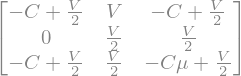

In [2]:
V,C,mu = symbols(' V C mu')

Payoff_matrix = Matrix([[V/2 - C, V, V/2-C],[0,V/2,V/2],[V/2-C,V/2,V/2-mu*C]])

Payoff_matrix

Assuming that all strategies have a base fitness of $\omega_0$ and that the effect of the interactions is factored by a selection coefficient $s$, we can obtain the fitness of each strategy:

In [3]:
#Variables for fitness
wh,wd,wr = symbols('omega_h omega_d omega_r')

#Parameters affecting fitness
w0,s,PD,PH = symbols('omega_0 s P_D P_H')

#Variables for fitness differences
alpha,beta = symbols('alpha beta')

wh = w0 + s*(PH*(V/2 - C)+PD*(V) + (1-PD-PH)*(V/2 - C))
wd = w0 + s*(PH*0 + PD*(V/2) + (1-PH-PD)*(V/2))
wr = w0 + s*(PH*(V/2-C)+PD*(V/2)+(1-PH-PD)*(V/2-mu*C))


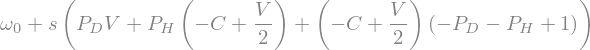

In [4]:
#fitness of hawks
wh

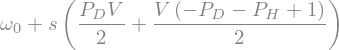

In [5]:
#fitness of doves
wd

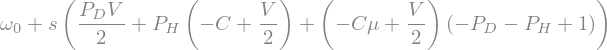

In [6]:
#fitness of reciprocators
wr

We can find the equations for nullclines - values at which two of the fitnesses are equal. Fixed points are given by the points at which all nullclines intersect.

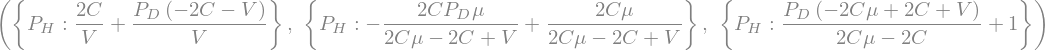

In [7]:
alpha = wh-wd
beta = wd-wr

h_d_nullcline = solve([alpha],PH,PD)
d_r_nullcline = solve([beta],PH,PD)
h_r_nullcline = solve([alpha+beta],PH,PD)


fixed_points = solve([alpha,beta],PH,PD)

h_d_nullcline, d_r_nullcline, h_r_nullcline

In [8]:
def h_d_null_func(pd,v,c,mu):
    null_sol = lambdify([V,C,PD],h_d_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd)
    pr = 1-pd-ph
    
    return (pd,pr,ph)

def d_r_null_func(pd,v,c,Mu):
    null_sol = lambdify([V,C,PD,mu],d_r_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd,Mu)
    pr = 1-pd-ph
    
    return (pd,pr,ph)

def h_r_null_func(pd,v,c,Mu):
    null_sol = lambdify([V,C,PD,mu],h_r_nullcline[PH],'numpy')
    ph = null_sol(v,c,pd,Mu)
    pr = 1-pd-ph
    
    return (pd,pr,ph)

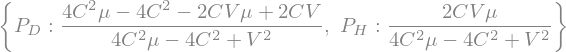

In [9]:
#Analytical solution for fixed points
fixed_points

We can find fixed points by plotting these nullclines on a simplex and looking at points of intersection: i.e plotting nullclines under the constraint that all are positive and that $P_H + P_D + P_R \leq 1$

In [10]:
def within_simplex(r): #Find out whether a given point lies within the S_1 simplex
    if r[0]+r[1]+r[2] <= 1 and r[0] >= 0 and r[1] >= 0 and r[2] >= 0:
        return True
    else:
        return False
    
#Convert the nullclines into Python functions
wd_func = lambdify([PD,PH,V,w0,s],wd)
wh_func = lambdify([PD,PH,V,C,w0,s],wh)
wr_func = lambdify([PD,PH,V,C,mu,w0,s],wr)

#Get the vector describing the trajectory at each point
#Trajectory is given by the replicator equation df/dt = (w-w_bar)f
def get_vector(pd,ph,v,c,mu,w0,s):
    
    #get the fitness values
    wd_val = wd_func(pd,ph,v,w0,s)
    wh_val = wh_func(pd,ph,v,c,w0,s)
    wr_val = wr_func(pd,ph,v,c,mu,w0,s)
    
    #Get relative fitness
    w_bar = pd*wd_val + ph*wh_val + (1-pd-ph)*wr_val
    wd_val -= w_bar
    wh_val -= w_bar
    wr_val -= w_bar
    
    #Project the 3D Cartesian coordinates onto a 2D simplex
    r_proj = project_point((pd,1-pd-ph,ph))
    dr_proj = project_point((pd*wd_val,(1-pd-ph)*wr_val,ph*wh_val))
    
    return r_proj,dr_proj

def get_color(pd,ph,v,c,mu,w0,s): #To indicate which strategy is best at that point
    
    wd = wd_func(pd,ph,v,w0,s)
    wh = wh_func(pd,ph,v,c,w0,s)
    wr = wr_func(pd,ph,v,c,mu,w0,s)
    
    if wd >= wh and wd >= wr:
        return 'red'
    if wh >= wd and wh >= wr:
        return 'green'
    if wr >= wh and wr >= wd:
        return 'blue'
    else:
        return 'black'   

In [13]:
def make_ternary_plot(V,C,mu,w0=0,s=1,plot_field=True,plot_nullclines=True,save=False,filename=''):
    
    figure, tax = ternary.figure(scale=1)

    fontsize = 16
    offset = 0.11
    
    #set background
    tax.set_background_color(color="#bbbbbb", alpha=0.7)
    
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=1, multiple=1)
    tax.gridlines(color="#aaaaaa", linestyle='-',linewidth=0.5, multiple=0.2,alpha=0.5)
    
    #Depict parameter values
    tax.set_title("V = "+ str(V) + "\nC = " + str(C) + "\n$\mu$ = " + str(mu) + '\nV/2C = ' + format(V/(2*C),'.2f'),position=(-0.05,1.5,-0.03),fontsize=18)

    #Label the axes and vertices
    tax.top_corner_label("Pure Reciprocator", fontsize=fontsize,position=(-0.1,1.2,-0.03),offset=0)
    tax.left_corner_label("Pure\nHawk", fontsize=fontsize,position=(-0.05,-0.01,1.1),offset=0)
    tax.right_corner_label("Pure\nDove", fontsize=fontsize,position=(1.05,0,-0.02),offset=0)
    tax.left_axis_label("$P_H$", fontsize=18, offset=0.16)
    tax.right_axis_label("$P_R$", fontsize=18, offset=0.16)
    tax.bottom_axis_label("$P_D$", fontsize=18, offset=0.16)
    
    if plot_nullclines:
        
        pd_list = np.arange(0,1.01,0.01)
        h_d_null = []
        h_r_null = []
        d_r_null = []
        for pd in pd_list:
        
            #Get the value of the H-D null
            tuple1 = h_d_null_func(pd,V,C,mu)
            if within_simplex(tuple1):
                h_d_null.append(tuple1)
        
            #Get the value of the H-R null
            tuple2 = h_r_null_func(pd,V,C,mu)
            if within_simplex(tuple2):
                h_r_null.append(tuple2)
        
            #Get the value of the D-R null
            tuple3 = d_r_null_func(pd,V,C,mu)
            if within_simplex(tuple3):
                d_r_null.append(tuple3)
    
        #Plot nullclines
        if len(h_d_null) > 0:
            tax.plot(h_d_null,linewidth=2.0,color='green',label='H-D nullcline')
        if len(h_r_null) > 0:
            tax.plot(h_r_null,linewidth=2.0,color='#0047ab',label='R-H nullcline')
        if len(d_r_null) > 0:
            tax.plot(d_r_null,linewidth=2.0,color='orange',label='D-R nullcline')
    
    #draw the vector field
    if plot_field:
        length = 0.02
        prop_list = np.arange(0,1.2,0.05)
        for pd in prop_list:
            for ph in prop_list:
                if within_simplex((pd,ph,1-pd-ph)):
                    r, dr = get_vector(pd,ph,V,C,mu,w0,s)
                    if np.hypot(dr[0],dr[1]) != 0:
                        dx,dy = length*dr/np.hypot(dr[0],dr[1])
                    else:
                        dx,dy = 0,0
                    color = get_color(pd,ph,V,C,mu,w0,s)
                    tax.get_axes().quiver(r[0],r[1],dx,dy,color=color,width=0.005,scale=0.1,scale_units='inches')
    
    tax.ticks(axis='lbr', fontsize=13, multiple=0.2, linewidth=0.5, tick_formats="%.1f",axes_colors={'l':'white','r':'white','b':'white'}, offset=0.02)    
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    tax.legend()
    
    if save:
        tax.savefig(str(filename+".png"))
    tax.show()

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/b_/xqbznk296tb4z4dhdrlrd4rr0000gn/T/ipykernel_6419/3399975650.py:17: SyntaxWarning: invalid escape sequence '\m'
  tax.set_title("V = "+ str(V) + "\nC = " + str(C) + "\n$\mu$ = " + str(mu) + '\nV/2C = ' + format(V/(2*C),'.2f'),position=(-0.05,1.5,-0.03),fontsize=18)


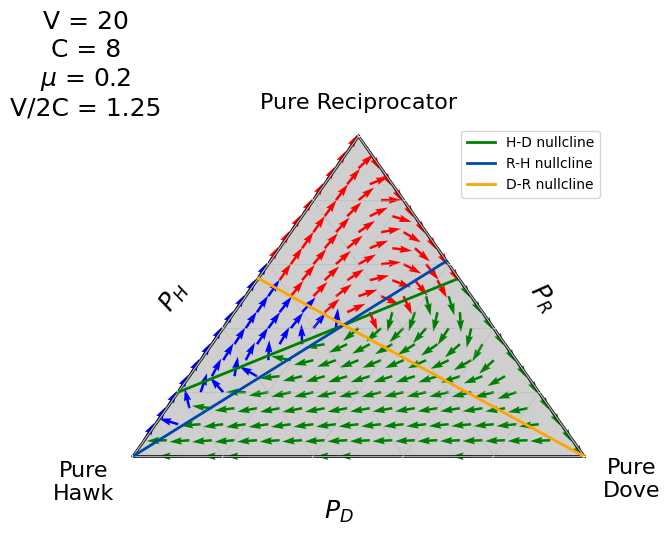

In [14]:
make_ternary_plot(20,8,0.2,save=False)